[Stanford cars dataset](https://ai.stanford.edu/~jkrause/cars/car_dataset.html):

* 3D Object Representations for Fine-Grained Categorization
Jonathan Krause, Michael Stark, Jia Deng, Li Fei-Fei
4th IEEE Workshop on 3D Representation and Recognition, at ICCV 2013 (3dRR-13). Sydney, Australia. Dec. 8, 2013.
[pdf]   [BibTex]   [slides]

In [ ]:
!pip install python-telegram-bot --upgrade

In [11]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [14]:
import numpy as np
import time

from glob import glob
from pathlib import Path

DATA_DIR = Path('./data')
PHOTOS_DIR = DATA_DIR / 'stanford'

TRAIN_DIR = PHOTOS_DIR / 'cars_train'

DEVKIT_PATH = PHOTOS_DIR / 'devkit'

MODELS_DIR = DATA_DIR / 'models'

train_files = glob(str(TRAIN_DIR /'*.jpg'))

In [3]:
len(train_files)
train_files[:5]
train_files[-5:]

8144

['data\\stanford\\cars_train\\00001.jpg',
 'data\\stanford\\cars_train\\00002.jpg',
 'data\\stanford\\cars_train\\00003.jpg',
 'data\\stanford\\cars_train\\00004.jpg',
 'data\\stanford\\cars_train\\00005.jpg']

['data\\stanford\\cars_train\\08140.jpg',
 'data\\stanford\\cars_train\\08141.jpg',
 'data\\stanford\\cars_train\\08142.jpg',
 'data\\stanford\\cars_train\\08143.jpg',
 'data\\stanford\\cars_train\\08144.jpg']

In [4]:
# import scipy.io
# cars_annos = scipy.io.loadmat(str(DEVKIT_PATH / 'cars_annos.mat'))
# cars_annos.keys()
# cars_annos['class_names'][0][:10]

# annotations = cars_annos['annotations']
# class_names = cars_annos['class_names']

In [4]:
import pandas as pd

labels = pd.read_csv(DEVKIT_PATH / 'labels_df.csv' )
labels.head()
labels.tail()

,filename,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class_id,class_name,is_test,filename_cropped,bbox_h,bbox_w
0,00001.jpg,39,116,569,375,14,Audi TTS Coupe 2012,0,cropped_00001.jpg,260,531
1,00002.jpg,36,116,868,587,3,Acura TL Sedan 2012,0,cropped_00002.jpg,472,833
2,00003.jpg,85,109,601,381,91,Dodge Dakota Club Cab 2007,0,cropped_00003.jpg,273,517
3,00004.jpg,621,393,1484,1096,134,Hyundai Sonata Hybrid Sedan 2012,0,cropped_00004.jpg,704,864
4,00005.jpg,14,36,133,99,106,Ford F-450 Super Duty Crew Cab 2012,0,cropped_00005.jpg,64,120


,filename,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class_id,class_name,is_test,filename_cropped,bbox_h,bbox_w
16180,test_08037.jpg,49,57,1169,669,63,Chevrolet Sonic Sedan 2012,1,test_08037.jpg,613,1121
16181,test_08038.jpg,23,18,640,459,16,Audi V8 Sedan 1994,1,test_08038.jpg,442,618
16182,test_08039.jpg,33,27,602,252,17,Audi 100 Sedan 1994,1,test_08039.jpg,226,570
16183,test_08040.jpg,33,142,521,376,38,BMW Z4 Convertible 2012,1,test_08040.jpg,235,489
16184,test_08041.jpg,77,73,506,380,32,BMW X5 SUV 2007,1,test_08041.jpg,308,430


In [5]:
from fastai import *
from fastai.vision import *
from fastai.utils.mem import *

In [6]:
car_tfms = get_transforms()
SZ = 300

data = ImageList.from_df(labels[labels.is_test == 0], TRAIN_DIR, cols='filename').split_by_rand_pct(.2).label_from_df(cols='class_name')

data = (data.transform(car_tfms, 
      size=SZ,  
      resize_method=ResizeMethod.SQUISH, 
      padding_mode='reflection')
    .databunch()
    .normalize(imagenet_stats))

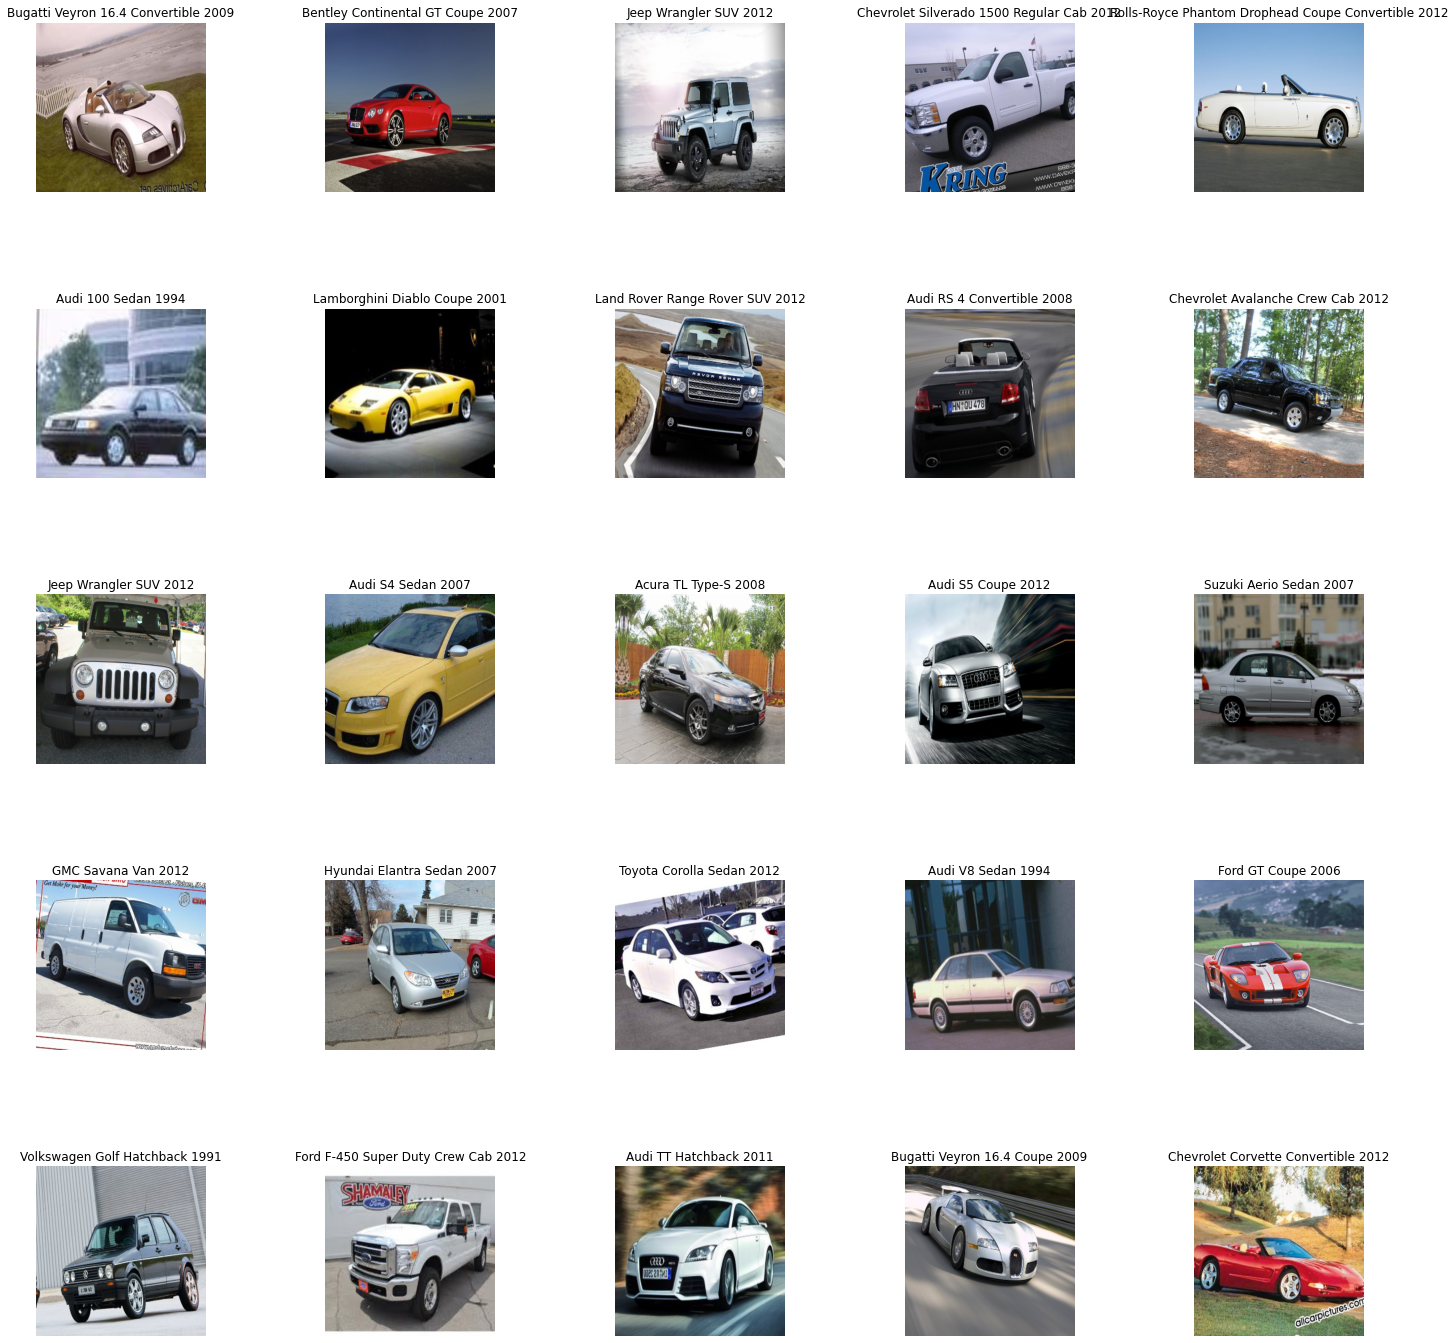

In [88]:
data.show_batch()

In [7]:
# By @muellerzr on the fastai forums:
# https://forums.fast.ai/t/meet-mish-new-activation-function-possible-successor-to-relu/53299/133       

from fastai.callbacks import *

def FlatCosAnnealScheduler(learn, lr:float=4e-3, tot_epochs:int=1, moms:Floats=(0.95,0.999),
                          start_pct:float=0.72, curve='cosine'):
    "Manage FCFit trainnig as found in the ImageNette experiments"
    n = len(learn.data.train_dl)
    anneal_start = int(n * tot_epochs * start_pct)
    batch_finish = ((n * tot_epochs) - anneal_start)
    if curve=="cosine":
        curve_type=annealing_cos
    elif curve=="linear":
        curve_type=annealing_linear
    elif curve=="exponential":
        curve_type=annealing_exp
    else:
        raiseValueError(f"annealing type not supported {curve}")

    phase0 = TrainingPhase(anneal_start).schedule_hp('lr', lr).schedule_hp('mom', moms[0])
    phase1 = TrainingPhase(batch_finish).schedule_hp('lr', lr, anneal=curve_type).schedule_hp('mom', moms[1])
    phases = [phase0, phase1]
    return GeneralScheduler(learn, phases)
                
def fit_fc(learn:Learner, tot_epochs:int=None, lr:float=defaults.lr,  moms:Tuple[float,float]=(0.95,0.85), start_pct:float=0.72,
                  wd:float=None, callbacks:Optional[CallbackList]=None, show_curve:bool=False)->None:
    "Fit a model with Flat Cosine Annealing"
    max_lr = learn.lr_range(lr)
    callbacks = listify(callbacks)
    callbacks.append(FlatCosAnnealScheduler(learn, lr, moms=moms, start_pct=start_pct, tot_epochs=tot_epochs))
    learn.fit(tot_epochs, max_lr, wd=wd, callbacks=callbacks)

In [8]:
def save_metrics_to_csv(exp_name, run_count, learn, metrics):
    for m in metrics:
        name = f'{m}_{exp_name}_run{str(run_count)}_2020-03_15'

        ls = []
        if m == 'val_loss_and_acc':
            acc = []
            for l in learn.recorder.metrics:
                 acc.append(l[0].item())
            ls = learn.recorder.val_losses 

            d = {name: ls, 'acc': acc}
            df = pd.DataFrame(d)
            #df.columns = [name, 'acc']
        elif m == 'trn_loss':
            for l in learn.recorder.losses:
                ls.append(l.item())
            df = pd.DataFrame(ls)
            df.columns = [name]

        df.to_csv(f'{name}_{m}.csv')
        print(df.head())

In [25]:
results = []

In [66]:
def perform_EfficientNet_training(model_name):
    model = EfficientNet.from_pretrained(model_name)
    learn = Learner(data, 
                    model=model,
                    wd = 1e-3,
                    bn_wd=False,
                    true_wd=True,
                    metrics=[accuracy],
                    loss_func=LabelSmoothingCrossEntropy(),
                    # callback_fns=BnFreeze
                   ).to_fp16()

    fit_fc(learn, tot_epochs=40, lr=15e-4, start_pct=0.1, wd=1e-3, show_curve=True)

    model_id = f'{model_name}-{time.strftime("%Y_%m_%d-%H_%M_%S")}'

    torch.save(model.state_dict, MODELS_DIR / model_id)

    result = {
    'model_name': model_name,
    'model_id': model_id,
    'model': model,
    'learner': learn
    }
    return result

In [80]:
from telegram.ext import Updater
from telegram.ext import CommandHandler
TELEGRAM_TOKEN = ''
CHAT_ID = ''

updater = Updater(token=TELEGRAM_TOKEN, use_context=True)
dispatcher = updater.dispatcher

def howis(update, context):
    context.bot.send_message(chat_id=update.effective_chat.id, text="Your training is fine, wait 10 more hours")

def getid(update, context):
    context.bot.send_message(chat_id=update.effective_chat.id, text=update.message.chat_id)

dispatcher.add_handler(CommandHandler('howis', howis))
dispatcher.add_handler(CommandHandler('getid', getid))
updater.start_polling()
bot = updater.bot

bot.send_message(chat_id = CHAT_ID, text = 'Training started.')
progress_msg_res = bot.send_message(chat_id = CHAT_ID, text = 'Iteration 0: loss: 1234')
bot.send_message(chat_id = CHAT_ID, text = 'Training ended. Took 1234 minutes.')

# progress_msg_res.edit_text('Iteration 1: loss: 1')

# embedding_img_path = './images/embedding.png'
# plot_embeddings(train_embeddings_baseline, train_labels_baseline, plt_store_path=embedding_img_path)
# bot.send_photo(chat_id = CHAT_ID, photo=open(embedding_img_path, 'rb'))
    

In [ ]:
model = EfficientNet.from_pretrained(model_name)

learn = Learner(data, 
                model=model,
                wd = 1e-3,
                bn_wd=False,
                true_wd=True,
                metrics=[accuracy],
                loss_func=LabelSmoothingCrossEntropy(),
                # callback_fns=BnFreeze
               ).to_fp16()

Loaded pretrained weights for efficientnet-b0
epoch	train_loss	valid_loss	accuracy	time
0	3.971122	3.963198	0.293612	04:12
1	2.405952	2.487717	0.587838	04:14
2	1.802018	2.105420	0.710074	04:14
3	1.567758	1.968032	0.755528	04:17
4	1.474287	1.951606	0.758600	04:15
5	1.398851	1.915794	0.769042	04:13
6	1.360708	1.920120	0.773342	04:12
7	1.318090	1.840323	0.795455	04:15
8	1.297676	1.967617	0.780098	04:15
9	1.270395	1.801071	0.808354	04:12
10	1.247139	1.942783	0.767199	04:13
11	1.224454	1.699962	0.835381	04:16
12	1.219437	1.744741	0.821867	04:13
13	1.202718	1.668553	0.846437	04:15
14	1.182241	1.820562	0.822482	04:16
15	1.179079	1.680595	0.852580	04:16
16	1.156192	1.657263	0.863022	04:15
17	1.145956	1.583643	0.871007	04:21
18	1.138100	1.578080	0.877764	04:21
19	1.123981	1.612454	0.880835	04:19
20	1.116726	1.650625	0.874079	04:18
21	1.110120	1.545655	0.893735	04:19
22	1.106800	1.498845	0.897420	04:20
23	1.095528	1.522315	0.903563	04:22
24	1.090245	1.490100	0.898649	04:20
25	1.085398	1.469460	0.909705	04:18
26	1.076496	1.468375	0.904177	04:19
27	1.073353	1.465575	0.909705	04:18
28	1.068480	1.453523	0.915848	04:20
29	1.064861	1.464249	0.917076	04:17
30	1.061648	1.448245	0.909091	04:16
31	1.059522	1.441067	0.912162	04:22
32	1.057429	1.438605	0.918305	04:13
33	1.054750	1.435364	0.920762	04:16
34	1.052774	1.438419	0.921990	04:15
35	1.051431	1.434561	0.923219	04:14
36	1.050917	1.433010	0.923219	04:14
37	1.049829	1.434861	0.923833	04:14
38	1.050546	1.435221	0.923219	04:14
39	1.050124	1.435816	0.923219	04:18

In [68]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from efficientnet_pytorch import EfficientNet

data.batch_size = 32
result = perform_EfficientNet_training(model_name = 'efficientnet-b0')
results.append(result)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to C:\Users\matowy/.cache\torch\checkpoints\efficientnet-b0-355c32eb.pth



Loaded pretrained weights for efficientnet-b0


epoch,train_loss,valid_loss,accuracy,time
0,3.520546,3.591724,0.354423,04:10
1,2.246784,2.791306,0.494472,04:08
2,1.882514,2.285807,0.657862,04:09
3,1.628808,2.273101,0.679975,04:11
4,1.557512,2.136451,0.694103,04:18
5,1.507607,2.001413,0.746315,04:18
6,1.434774,1.927237,0.770270,04:12
7,1.384619,1.878708,0.778870,04:28
8,1.361013,1.934909,0.767199,04:12
9,1.323561,2.056838,0.746315,04:05


KeyboardInterrupt: 

In [10]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# from ranger import Ranger

from efficientnet_pytorch import EfficientNet

model_name = 'efficientnet-b1'
model = EfficientNet.from_pretrained(model_name)

data.batch_size = 32

learn = Learner(data, 
                model=model,
                wd = 1e-3,
#                 opt_func=Ranger,
                bn_wd=False,
                true_wd=True,
                metrics=[accuracy],
                loss_func=LabelSmoothingCrossEntropy(),
                # callback_fns=BnFreeze
               ).to_fp16()

fit_fc(learn, tot_epochs=40, lr=15e-4, start_pct=0.1, wd=1e-3, show_curve=True)

model_id = f'{model_name}-{time.strftime("%Y_%m_%d-%H_%M_%S")}'

torch.save(model.state_dict, MODELS_DIR / model_id)
results.append({
    'model_name': model_name,
    'model_id': model_id,
    'model': model,
    'learner': learn
})

epoch,train_loss,valid_loss,accuracy,time
0,3.647295,4.364075,0.205774,04:54
1,2.271918,2.598486,0.550983,05:05
2,1.863864,2.329342,0.641278,05:06
3,1.640076,2.057123,0.711302,04:54
4,1.581948,2.584359,0.597052,04:54
5,1.496435,1.888190,0.778870,04:58
6,1.421636,2.094035,0.738944,05:03
7,1.379514,1.883967,0.789926,04:53
8,1.333675,1.876117,0.786241,04:53
9,1.320284,1.907337,0.785627,05:03


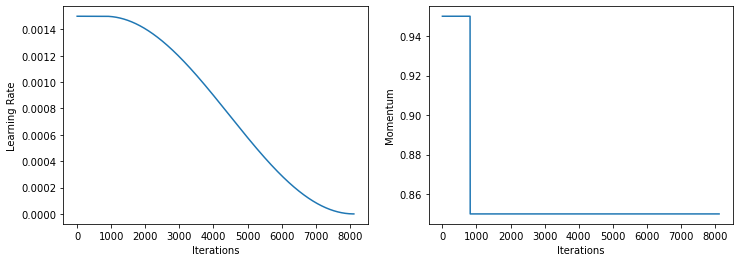

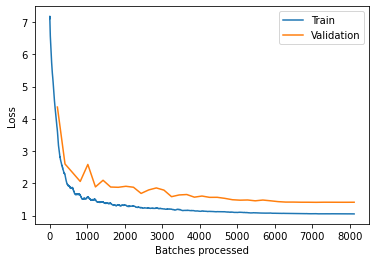

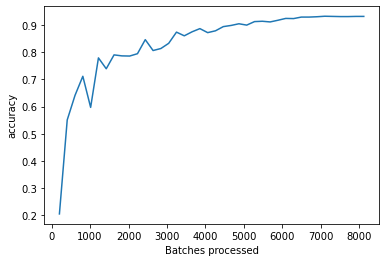

In [65]:
learn.recorder.plot_lr(show_moms=True)
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [62]:
pd.DataFrame({'val_losses': pd.Series(learn.recorder.val_losses), 'acc':pd.Series([m[0].item() for m in learn.recorder.metrics])})

,val_losses,acc
0,4.364075,0.205774
1,2.598486,0.550983
2,2.329342,0.641278
3,2.057123,0.711302
4,2.584359,0.597052
5,1.888190,0.778870
6,2.094035,0.738944
7,1.883967,0.789926
8,1.876117,0.786241
9,1.907337,0.785627
